# Import Library & Load File

In [ ]:
!pip install scikit-surprise

In [ ]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import warnings; warnings.simplefilter('ignore')

In [ ]:
# Menghubungkan notebook dengan Google Drive

from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
movies_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Movies/movies_metadata.csv')

In [ ]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# Exploratory Data Analysis (EDA)

In [ ]:
movies_df['title'] = movies_df['title'].astype('str')
movies_df['overview'] = movies_df['overview'].astype('str')

In [ ]:
title_corpus = ' '.join(movies_df['title'])
overview_corpus = ' '.join(movies_df['overview'])

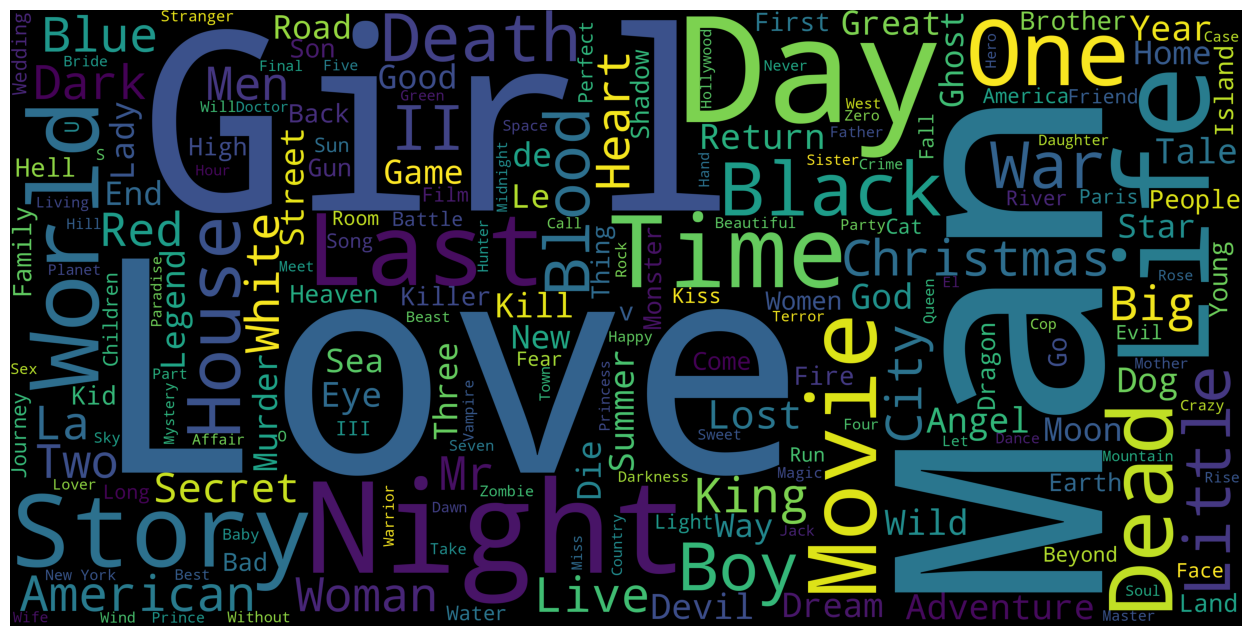

In [ ]:
# Melihat kata yang sering muncul dalam setiap judul Film

title_wc = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wc)
plt.axis('off')
plt.show()

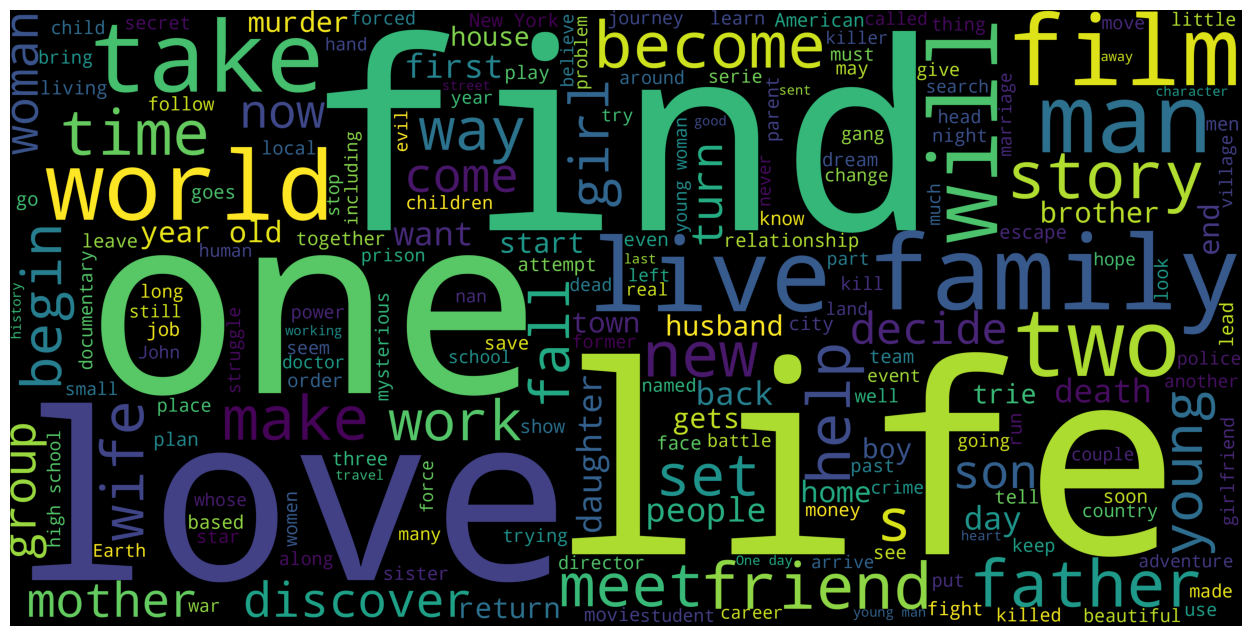

In [ ]:
# Melihat kata yang sering muncul dalam setiap Deskripsi Film

overview_wc = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wc)
plt.axis('off')
plt.show()

In [ ]:
# Mendefinisikan fungsi anotasi banyaknya data pada visualisasi

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [ ]:
# Mengambil nama negara asal Film

movies_df['country'] = movies_df['production_countries'].fillna('[]').apply(ast.literal_eval)
movies_df['country'] = movies_df['country'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df['country'].head()

0    [United States of America]
1    [United States of America]
2    [United States of America]
3    [United States of America]
4    [United States of America]
Name: country, dtype: object

In [ ]:
s = movies_df.apply(lambda x: pd.Series(x['country']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'country'

In [ ]:
movies_df = movies_df.drop('country', axis=1).join(s)
movies_df['country'] = movies_df['country'].replace('United States of America', 'USA')
movies_df['country'] = movies_df['country'].replace('United Kingdom', 'UK')

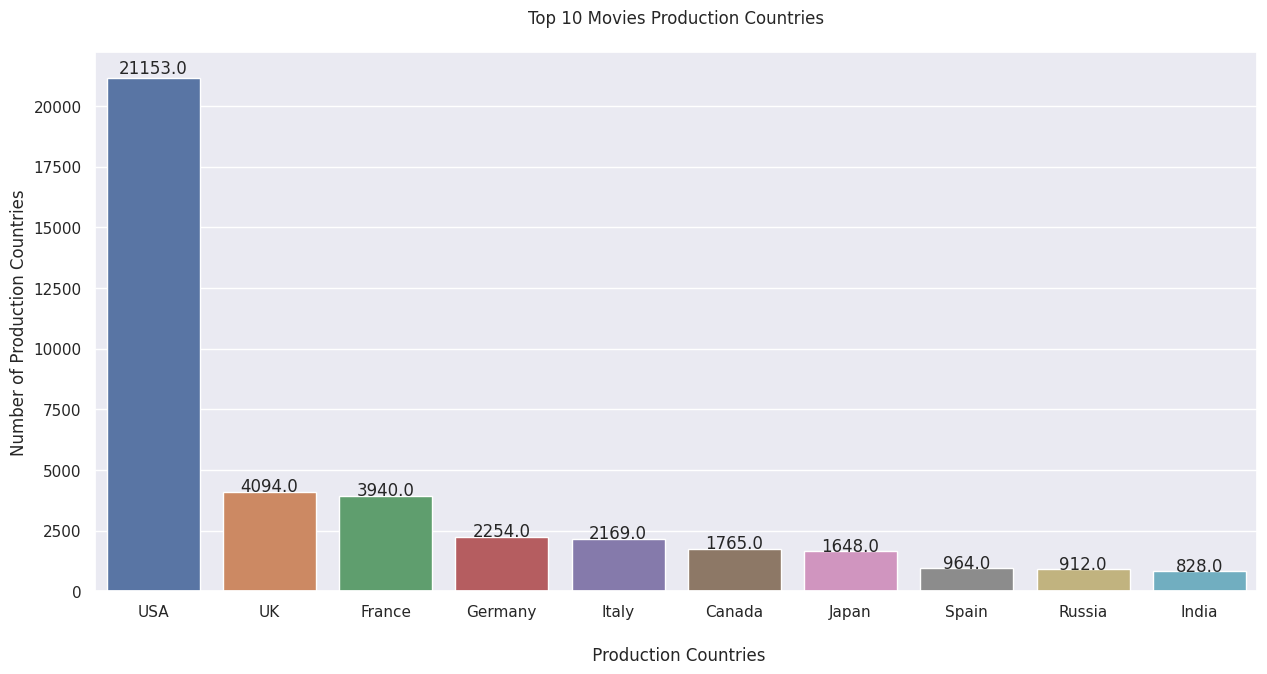

In [ ]:
# Eksplor 10 negara asal Film terbanyak

countries = movies_df['country'].value_counts().sort_values(ascending=False).head(10)
countries = pd.DataFrame(countries)
countries = countries.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(15, 7))
con_plt = sns.barplot(x='index', y='country', data=countries)

show_values(con_plt, 'v', space=0)

plt.xlabel("\n Production Countries")
plt.ylabel("Number of Production Countries")
plt.title("Top 10 Movies Production Countries\n")
plt.show()

In [ ]:
movies_df['company'] = movies_df['production_companies'].fillna('[]').apply(ast.literal_eval)
movies_df['company'] = movies_df['company'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df['company']

0                                [Pixar Animation Studios]
1        [TriStar Pictures, Teitler Film, Interscope Co...
2                           [Warner Bros., Lancaster Gate]
3                 [Twentieth Century Fox Film Corporation]
4             [Sandollar Productions, Touchstone Pictures]
                               ...                        
45461                                                   []
45462                                        [Sine Olivia]
45463                            [American World Pictures]
45464                                          [Yermoliev]
45465                                                   []
Name: company, Length: 55711, dtype: object

In [ ]:
c = movies_df.apply(lambda x: pd.Series(x['company']),axis=1).stack().reset_index(level=1, drop=True)
c.name = 'company'
movies_df = movies_df.drop('company', axis=1).join(c)

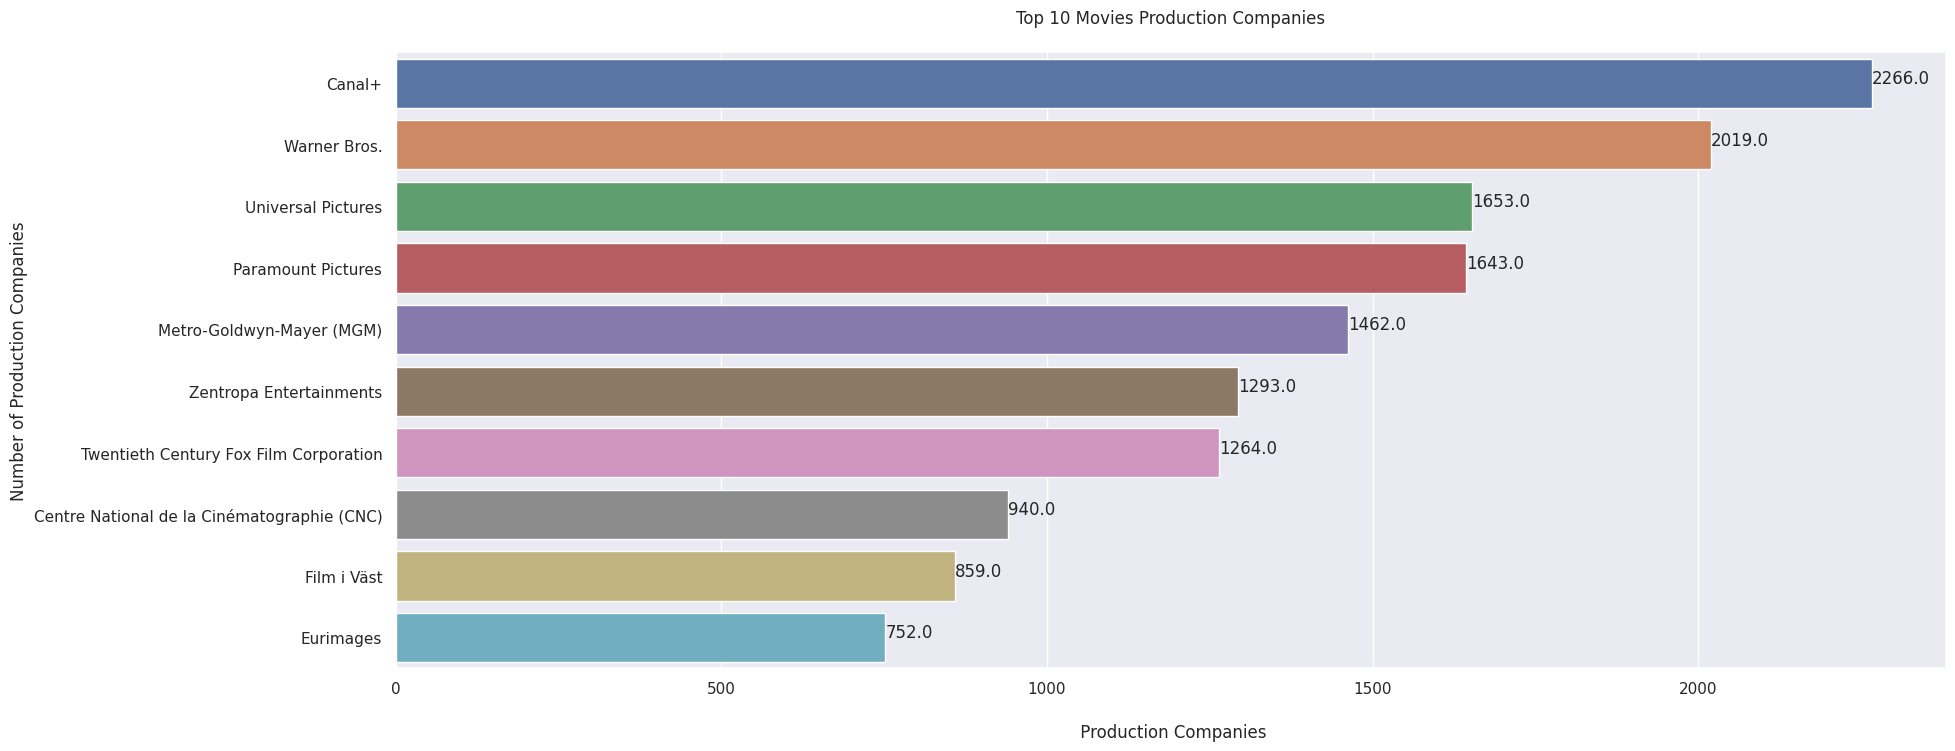

In [ ]:
# Eksplor 10 studio produsen Film terbanyak

company = movies_df['company'].value_counts().sort_values(ascending=False).head(10)
company = pd.DataFrame(company)
company = company.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(20, 8))
com_plt = sns.barplot(x='company', y='index', data=company, orient='h')

show_values(com_plt, "h", space=0)

plt.xlabel("\n Production Companies")
plt.ylabel("Number of Production Companies")
plt.title("Top 10 Movies Production Companies\n")
plt.show()

# Data Preparation

In [ ]:
# Load dataset Links
links_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Movies/links_small.csv')
links_df = links_df[links_df['tmdbId'].notnull()]['tmdbId'].astype('int')
links_df.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [ ]:
# Menambahkan kolom 'year'
movies_df['year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
movies_df = movies_df.drop([19730, 29503, 35587])

In [ ]:
movies_df['id'] = movies_df['id'].astype('int')

In [ ]:
mov_link = movies_df[movies_df['id'].isin(links_df)]

In [ ]:
mov_link.drop_duplicates(subset=['title', 'overview'], inplace=True)

In [ ]:
mov_link.shape

(9079, 27)

In [ ]:
mov_link['mov_genre'] = mov_link['genres'].fillna('[]').apply(ast.literal_eval)

In [ ]:
# Ekstrak 'name' dari list of dictionary di kolom 'genres'
mov_link['mov_genre'] = mov_link['mov_genre'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
mov_link['mov_genre'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: mov_genre, dtype: object

In [ ]:
mov_link['tagline'] = mov_link['tagline'].fillna('')
mov_link['description'] = mov_link['overview'] + mov_link['tagline']
mov_link['description'] = mov_link['description'].fillna('')

In [ ]:
# Tokenizing setiap kata dalam corpus

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(mov_link['description'])

In [ ]:
tfidf_matrix.shape

(9079, 268114)

# Model Training

In [ ]:
# Menghitung cosine similarity

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[1]

array([0.00680255, 1.        , 0.0153061 , ..., 0.        , 0.00175186,
       0.00368055])

In [ ]:
mov_link = mov_link.reset_index()
titles = mov_link['title']
indices = pd.Series(mov_link.index, index=mov_link['title'])

In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Movies/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
# Inisiasi dan evaluasi model SVD dengan 5-fold cross-validation

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9034  0.8985  0.8995  0.8920  0.8949  0.8977  0.0039  
MAE (testset)     0.6932  0.6928  0.6899  0.6888  0.6895  0.6908  0.0018  
Fit time          1.21    1.81    1.40    1.15    1.11    1.34    0.26    
Test time         0.24    0.42    0.15    0.13    0.13    0.21    0.11    


{'test_rmse': array([0.90342103, 0.89851519, 0.89954804, 0.89197931, 0.89489408]),
 'test_mae': array([0.69318762, 0.69278572, 0.68986343, 0.68876454, 0.68953067]),
 'fit_time': (1.213393211364746,
  1.8061442375183105,
  1.4022128582000732,
  1.1462295055389404,
  1.1148090362548828),
 'test_time': (0.23593950271606445,
  0.4173896312713623,
  0.14920258522033691,
  0.12958407402038574,
  0.1310577392578125)}

In [ ]:
# Train model dengan semua data latih

trainset = data.build_full_trainset()
svd.fit(trainset)

# Hybrid Filtering (Mixed)

In [ ]:
# Mendefinisikan fungsi konversi integer

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Movies/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(mov_link[['title', 'id']], on='id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
# Fungsi Mixed Hybrid Recommendation
def hybrid_recommend(userId, title, n=5):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']

    # Mendapatkan Top 25 Film yang mirip dengan judul input
    sim_score = list(enumerate(cosine_sim[int(idx)]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[1:30]
    movie_indices = [i[0] for i in sim_score]

    # Mencari film yang paling sesuai dengan pengguna
    movies = mov_link.iloc[movie_indices][['title', 'year', 'vote_count', 'vote_average', 'id', 'mov_genre']]
    movies['rating_est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('rating_est', ascending=False)
    return movies.head(n)

In [ ]:
hybrid_recommend(3000, 'Spectre', 10)

,title,year,vote_count,vote_average,id,mov_genre,rating_est
6553,Casino Royale,2006,3930.0,7.3,36557,"[Adventure, Action, Thriller]",3.926588
8081,Skyfall,2012,7718.0,6.9,37724,"[Action, Adventure, Thriller]",3.924010
2897,The Spy Who Loved Me,1977,515.0,6.6,691,"[Adventure, Action, Thriller]",3.731661
2895,On Her Majesty's Secret Service,1969,464.0,6.5,668,"[Adventure, Action, Thriller]",3.725076
6983,Watchmen,2009,2892.0,7.0,13183,"[Action, Mystery, Science Fiction]",3.704353
2363,Dr. No,1962,953.0,6.9,646,"[Adventure, Action, Thriller]",3.670961
2900,The Man with the Golden Gun,1974,533.0,6.4,682,"[Adventure, Action, Thriller]",3.663120
5754,The Tall Blond Man with One Black Shoe,1972,58.0,6.9,12089,"[Comedy, Mystery]",3.657653
2362,From Russia with Love,1963,773.0,6.9,657,"[Action, Thriller, Adventure]",3.638990
4942,To Live and Die in L.A.,1985,129.0,6.8,9846,"[Action, Crime, Thriller]",3.621542


In [ ]:
hybrid_recommend(404, 'Spectre', 10)

,title,year,vote_count,vote_average,id,mov_genre,rating_est
6553,Casino Royale,2006,3930.0,7.3,36557,"[Adventure, Action, Thriller]",4.000000
8081,Skyfall,2012,7718.0,6.9,37724,"[Action, Adventure, Thriller]",3.838095
2897,The Spy Who Loved Me,1977,515.0,6.6,691,"[Adventure, Action, Thriller]",3.715932
6983,Watchmen,2009,2892.0,7.0,13183,"[Action, Mystery, Science Fiction]",3.682757
8244,Safe Haven,2013,840.0,6.9,112949,[Romance],3.662248
5754,The Tall Blond Man with One Black Shoe,1972,58.0,6.9,12089,"[Comedy, Mystery]",3.647671
2895,On Her Majesty's Secret Service,1969,464.0,6.5,668,"[Adventure, Action, Thriller]",3.633573
2399,Thunderball,1965,572.0,6.5,660,"[Adventure, Action, Thriller]",3.628781
3202,The Living Daylights,1987,447.0,6.2,708,"[Action, Adventure, Thriller]",3.610363
4942,To Live and Die in L.A.,1985,129.0,6.8,9846,"[Action, Crime, Thriller]",3.597934


# Content-Based Filtering

In [ ]:
def cb_recommend(title, n=5):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']

    # Mendapatkan Top 30 Film yang mirip dengan judul input
    sim_score = list(enumerate(cosine_sim[int(idx)]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[1:30]
    movie_indices = [i[0] for i in sim_score]

    movies = mov_link.iloc[movie_indices][['title', 'year', 'vote_count', 'vote_average', 'id', 'mov_genre']]
    movies = movies.sort_values('vote_count', ascending=False)
    return movies.head(n)

In [ ]:
mov_link['mov_genre'][mov_link['title'] == 'Spectre']

8889    [Action, Adventure, Crime]
Name: mov_genre, dtype: object

In [ ]:
cb_recommend('Spectre', 10)

,title,year,vote_count,vote_average,id,mov_genre
8081,Skyfall,2012,7718.0,6.9,37724,"[Action, Adventure, Thriller]"
6553,Casino Royale,2006,3930.0,7.3,36557,"[Adventure, Action, Thriller]"
7054,Quantum of Solace,2008,3015.0,6.1,10764,"[Adventure, Action, Thriller, Crime]"
6983,Watchmen,2009,2892.0,7.0,13183,"[Action, Mystery, Science Fiction]"
4346,Die Another Day,2002,1112.0,5.8,36669,"[Adventure, Action, Thriller]"
2363,Dr. No,1962,953.0,6.9,646,"[Adventure, Action, Thriller]"
8244,Safe Haven,2013,840.0,6.9,112949,[Romance]
2362,From Russia with Love,1963,773.0,6.9,657,"[Action, Thriller, Adventure]"
2399,Thunderball,1965,572.0,6.5,660,"[Adventure, Action, Thriller]"
3183,Diamonds Are Forever,1971,562.0,6.3,681,"[Adventure, Action, Thriller]"


In [ ]:
mov_link['mov_genre'][mov_link['title'] == 'Avengers: Age of Ultron']

8746    [Action, Adventure, Science Fiction]
Name: mov_genre, dtype: object

In [ ]:
cb_recommend('Avengers: Age of Ultron', 10)

,title,year,vote_count,vote_average,id,mov_genre
7862,The Avengers,2012,12000.0,7.4,24428,"[Science Fiction, Action, Adventure]"
6923,Iron Man,2008,8951.0,7.4,1726,"[Action, Science Fiction, Adventure]"
8278,Iron Man 3,2013,8951.0,6.8,68721,"[Action, Adventure, Science Fiction]"
8750,Captain America: Civil War,2016,7462.0,7.1,271110,"[Adventure, Action, Science Fiction]"
7500,Iron Man 2,2010,6969.0,6.6,10138,"[Adventure, Action, Science Fiction]"
8725,Kingsman: The Secret Service,2015,6069.0,7.6,207703,"[Crime, Comedy, Action, Adventure]"
8512,Captain America: The Winter Soldier,2014,5881.0,7.6,100402,"[Action, Adventure, Science Fiction]"
8021,Men in Black 3,2012,4228.0,6.3,41154,"[Action, Comedy, Science Fiction]"
1569,Back to the Future Part II,1989,3926.0,7.4,165,"[Adventure, Comedy, Family, Science Fiction]"
8074,Total Recall,2012,2540.0,5.8,64635,"[Action, Science Fiction, Adventure, Thriller]"
